# FDA Course Homework
### Please implement 3 classifiers to predict the stock movement.
* Logistic Regression
* SVM
* Neural Network

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
import time
from sklearn import linear_model, metrics, model_selection
from keras import models, layers, optimizers, regularizers
from tqdm import tqdm
from sklearn import svm

Using TensorFlow backend.


## Dataset Preprocess 
1. 將 Close Price （與前一天比較的）漲跌，存成新的 Column
2. 切割資料：將 02-Jan-2009 ~ 29-Dec-2017 的資料設定為 Training_Data，將 02-Jan-2018 ~ 31-Dec-2018 的資料設定為 Testing_Data
3. 資料視覺化：繪製散布圖與熱圖，做為選擇變數的依據
4. 新增潛在變數：將 Open Price、High Price、Low Price （與前一天比較的）漲跌，存成新的 Column
5. 重新繪製熱圖：做為選擇變數的依據
6. 變數選取：選取相關係數 > 0.05 的變數為預測變數，最終以 Open Price、High Price、Low Price 的漲跌做為 Close Price 漲跌的預測依據
7. 切割資料：將資料分割成 train_X, train_y, test_X, test_y

In [2]:
pd_data = pd.read_csv ( "download.csv" )
pd_data [ "index" ] = pd_data.index

# Dataset Preprocess
# 1. 將 Close Price（與前一天比較的）漲跌，存成新的 Column
# 將 "Close Price" 欄位的值前後相減
# 相減的值 > 0 則 return True，反之 return False
# 用 astype ("int") 將 True、False 轉換成 1、0
pd_data [ "Close Price Rise or Fall" ] = 0
pd_data [ "Close Price Rise or Fall" ] = ( pd_data.iloc[:,2].diff() > 0 ).astype('int')

# Dataset Preprocess
# 2. 切割資料 
# Training_Data 02-Jan-2009 ~ 29-Dec-2017
Training_Data = pd_data [ 0 : int ( pd_data [ "index" ] [ pd_data ["Date"] == "29-Dec-2017" ] )]
# Testing_Data 02-Jan-2018 ~ 31-Dec-2018
Testing_Data = pd_data  [ int ( pd_data [ "index" ] [ pd_data ["Date"] == "29-Dec-2017" ] ) + 1 : ]

pd_data

,Date,Open Price,Close Price,High Price,Low Price,Volume,index,Close Price Rise or Fall
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,0,0
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,1,0
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,2,1
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,3,0
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,4,1
5,09-Jan-2009,909.91,890.35,911.93,888.31,4716499968,5,0
6,12-Jan-2009,890.40,870.26,890.40,864.32,4725049856,6,0
7,13-Jan-2009,869.79,871.79,877.02,862.02,5017469952,7,1
8,14-Jan-2009,867.28,842.62,867.28,836.93,5407880192,8,0
9,15-Jan-2009,841.99,843.74,851.59,817.04,7807350272,9,1


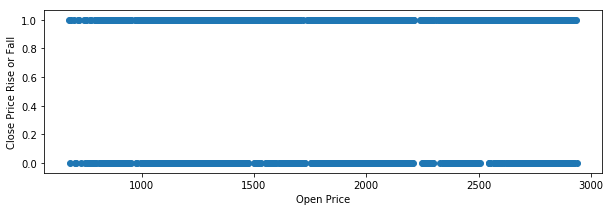

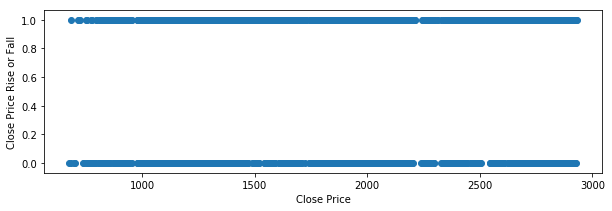

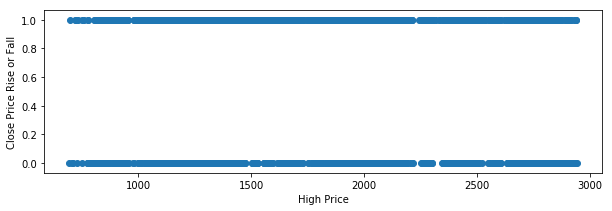

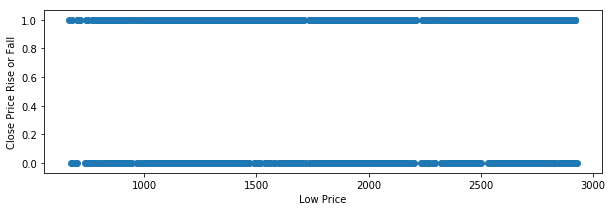

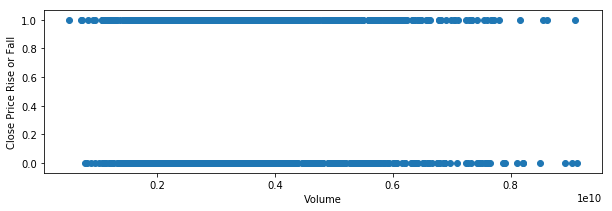

In [3]:
# Dataset Preprocess
# 3. 繪製散布圖

def plot_feature ( data, feature_name ):
    plt.figure ( figsize = ( 10, 3 ))
    plt.scatter ( data [ feature_name ], data [ "Close Price Rise or Fall" ] )
    plt.xlabel ( feature_name )
    plt.ylabel ( 'Close Price Rise or Fall' )
    plt.show()

plot_feature ( pd_data, "Open Price" )
plot_feature ( pd_data, "Close Price" )
plot_feature ( pd_data, "High Price" )
plot_feature ( pd_data, "Low Price" )
plot_feature ( pd_data, "Volume" )

#### 由以上散布圖可以發現資料散布均勻，難以直接以分類器分出類別，因此需要將資料做額外的處理

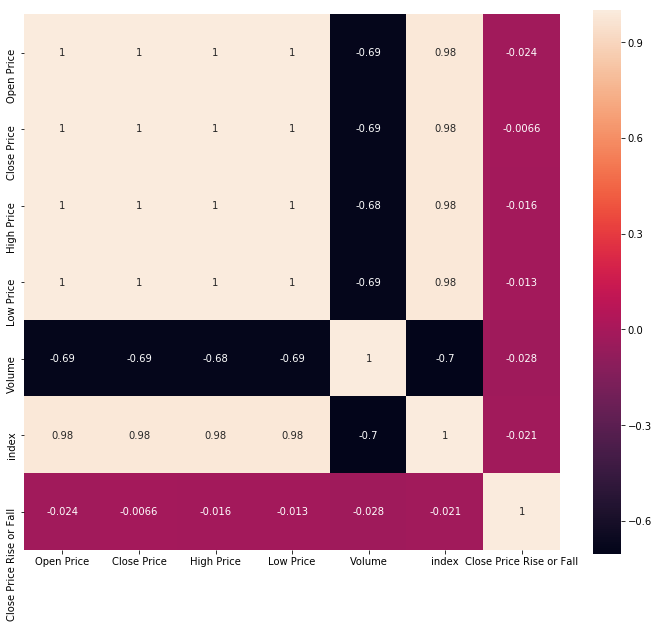

In [4]:
# Dataset Preprocess
# 3. 繪製熱圖

plt.figure ( figsize = ( 12, 10 ) )
foo = sns.heatmap ( pd_data.corr(), square = True, annot = True)

#### 由以上熱圖可以發現原資料與所預測的值無明顯相關性，難以直接以分類器分出類別，因此需要將資料做額外的處理

In [5]:
# Dataset Preprocess
# 4. 將 Open Price、High Price、Low Price （與前一天比較的）漲跌，存成新的 Column
pd_data [ "Open Price Rise or Fall" ] = 0
pd_data [ "Open Price Rise or Fall" ] = ( pd_data.iloc[:,1].diff() > 0 ).astype('int')
pd_data [ "High Price Rise or Fall" ] = 0
pd_data [ "High Price Rise or Fall" ] = ( pd_data.iloc[:,3].diff() > 0 ).astype('int')
pd_data [ "Low Price Rise or Fall" ] = 0
pd_data [ "Low Price Rise or Fall" ] = ( pd_data.iloc[:,4].diff() > 0 ).astype('int')

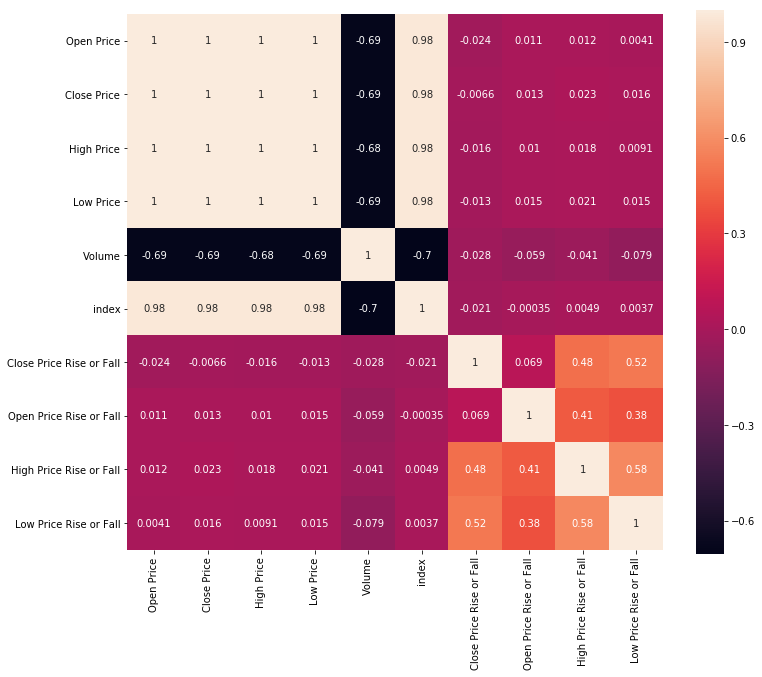

In [6]:
# Dataset Preprocess
# 5. 重新繪製熱圖

plt.figure ( figsize = ( 12, 10 ) )
foo = sns.heatmap ( pd_data.corr(), square = True, annot = True)

# Dataset Preprocess
# 6. 變數選取：選取相關係數 > 0.05 的變數為預測變數，最終以 Open Price、High Price、Low Price 的漲跌做為 Close Price 漲跌的預測依據

In [7]:
# Dataset Preprocess
# 7. 切割資料：將資料分割成 train_X, train_y, test_X, test_y

# 將欄位重新排序
pd_data = pd_data [[ "Date", "Open Price", "Close Price", "High Price", "Low Price", "Volume", "index", "Open Price Rise or Fall", "High Price Rise or Fall", "Low Price Rise or Fall", "Close Price Rise or Fall" ]]
pd_data [ "index" ] = pd_data.index
# Training_Data 02-Jan-2009 ~ 29-Dec-2017
Training_Data = pd_data [ 0 : int ( pd_data [ "index" ] [ pd_data ["Date"] == "29-Dec-2017" ] )]
# Testing_Data 02-Jan-2018 ~ 31-Dec-2018
Testing_Data = pd_data  [ int ( pd_data [ "index" ] [ pd_data ["Date"] == "29-Dec-2017" ] ) + 1 : ]

train_X, train_y = ( Training_Data.iloc [:,7:10] ), ( Training_Data.iloc [:,-1] )
test_X, test_y = ( Testing_Data.iloc [:,7:10] ), ( Testing_Data.iloc [:,-1] )

## Model Selecting

### SVC

In [8]:
SVC_classifier = SVC ( C = 0.01, kernel = "rbf", probability = True )
SVC_classifier.fit ( train_X, train_y )
predict_y = SVC_classifier.predict ( test_X )
pd.Series ( predict_y )

Accuracy = accuracy_score ( test_y, pd.Series ( predict_y ) ) * 100
print ( "Accuracy = %.2f %%" % ( Accuracy ))
# ( C = 0.01, kernal = "linear" ) Accuracy = 81.75 %
# ( C = 0.01, kernal = "rbf" ) Accuracy = 82.14 %

Accuracy = 82.14 %


### SVR

In [9]:
SVR_classifier = SVR ( C = 0.1, gamma = 0.01, kernel = "rbf" )
SVR_classifier.fit ( train_X, train_y )
predict_y = SVR_classifier.predict ( test_X )
predict_y

predict_y [ predict_y > 0.5 ] = 1
predict_y [ predict_y <= 0.5 ] = 0

Accuracy = accuracy_score ( test_y, pd.Series ( predict_y ) ) * 100
print ( "Accuracy = %.2f %%" % ( Accuracy ))
# Accuracy = 80.95 %

Accuracy = 80.95 %


### Logistic Regression

In [10]:
LogisticRegression_classifier = LogisticRegression().fit ( train_X, train_y )
LogisticRegression_classifier.fit ( train_X, train_y )
predict_y = LogisticRegression_classifier.predict ( test_X )  
Accuracy = metrics.accuracy_score ( test_y, predict_y ) * 100
    
print ( "Accuracy = %.2f %%" % ( Accuracy ) )

Accuracy = 81.75 %


### Neural Network

In [11]:
hidden_units = 10    # how many neurons in the hidden layer
activation = 'sigmoid'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.01  # how big our steps are in gradient descent
epochs = 50          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

In [12]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add ( layers.Dense ( input_dim = 3,
                       units = hidden_units, 
                       activation = activation ) )

# add the output layer
model.add ( layers.Dense ( input_dim = hidden_units,
                       units = 1,
                       activation = 'sigmoid' ) )

# define our loss function and optimizer
model.compile ( loss = 'binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer = optimizers.Adam ( lr = learning_rate ),
              metrics = [ 'accuracy' ] )

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
class_weight = {
    0 : 1 - sum ( train_y ) / len ( train_y ),
    1 : sum ( train_y ) / len ( train_y )
}

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2263/2263 [==============================] - ETA: 43s - loss: 0.4164 - acc: 0.43 - ETA: 0s - loss: 0.3356 - acc: 0.5492 - ETA: 0s - loss: 0.3180 - acc: 0.581 - 1s 328us/step - loss: 0.3166 - acc: 0.5926
Epoch 2/100
2263/2263 [==============================] - ETA: 0s - loss: 0.2876 - acc: 0.687 - ETA: 0s - loss: 0.2791 - acc: 0.739 - ETA: 0s - loss: 0.2678 - acc: 0.741 - 0s 54us/step - loss: 0.2652 - acc: 0.7450
Epoch 3/100
2263/2263 [==============================] - ETA: 0s - loss: 0.3334 - acc: 0.562 - ETA: 0s - loss: 0.2475 - acc: 0.766 - ETA: 0s - loss: 0.2471 - acc: 0.777 - 0s 52us/step - loss: 0.2469 - acc: 0.7791
Epoch 4/100
2263/2263 [==============================] - ETA: 0s - loss: 0.1914 - acc: 0.875 - ETA: 0s - loss: 0.2430 - acc: 0.797 - ETA: 0s - loss: 0.2452 - acc: 0.790 - 0s 58us/step - loss: 0.2433 - acc: 0.7950
Epoch 5/100
2263/2263 [==============================] - ETA: 0s - loss: 0.2114 - acc: 0.812 - ETA

2263/2263 [==============================] - ETA: 0s - loss: 0.1855 - acc: 0.875 - ETA: 0s - loss: 0.2498 - acc: 0.793 - ETA: 0s - loss: 0.2437 - acc: 0.793 - 0s 64us/step - loss: 0.2425 - acc: 0.7950
Epoch 38/100
2263/2263 [==============================] - ETA: 0s - loss: 0.2856 - acc: 0.718 - ETA: 0s - loss: 0.2487 - acc: 0.792 - ETA: 0s - loss: 0.2468 - acc: 0.789 - 0s 61us/step - loss: 0.2412 - acc: 0.7950
Epoch 39/100
2263/2263 [==============================] - ETA: 0s - loss: 0.2675 - acc: 0.750 - ETA: 0s - loss: 0.2451 - acc: 0.803 - ETA: 0s - loss: 0.2452 - acc: 0.795 - ETA: 0s - loss: 0.2412 - acc: 0.797 - 0s 77us/step - loss: 0.2421 - acc: 0.7950
Epoch 40/100
2263/2263 [==============================] - ETA: 0s - loss: 0.3551 - acc: 0.656 - ETA: 0s - loss: 0.2424 - acc: 0.792 - 0s 46us/step - loss: 0.2415 - acc: 0.7950
Epoch 41/100
2263/2263 [==============================] - ETA: 0s - loss: 0.1943 - acc: 0.875 - ETA: 0s - loss: 0.2411 - acc: 0.798 - ETA: 0s - loss: 0.2391 

2263/2263 [==============================] - ETA: 0s - loss: 0.2697 - acc: 0.781 - ETA: 0s - loss: 0.2438 - acc: 0.790 - ETA: 0s - loss: 0.2398 - acc: 0.797 - 0s 57us/step - loss: 0.2412 - acc: 0.7950
Epoch 74/100
2263/2263 [==============================] - ETA: 0s - loss: 0.2038 - acc: 0.843 - ETA: 0s - loss: 0.2439 - acc: 0.789 - 0s 44us/step - loss: 0.2414 - acc: 0.7950
Epoch 75/100
2263/2263 [==============================] - ETA: 0s - loss: 0.2954 - acc: 0.750 - ETA: 0s - loss: 0.2445 - acc: 0.794 - ETA: 0s - loss: 0.2435 - acc: 0.795 - 0s 60us/step - loss: 0.2411 - acc: 0.7950
Epoch 76/100
2263/2263 [==============================] - ETA: 0s - loss: 0.2459 - acc: 0.812 - ETA: 0s - loss: 0.2491 - acc: 0.779 - ETA: 0s - loss: 0.2400 - acc: 0.791 - 0s 68us/step - loss: 0.2410 - acc: 0.7950
Epoch 77/100
2263/2263 [==============================] - ETA: 0s - loss: 0.3280 - acc: 0.625 - ETA: 0s - loss: 0.2546 - acc: 0.781 - ETA: 0s - loss: 0.2436 - acc: 0.795 - 0s 55us/step - loss: 0.

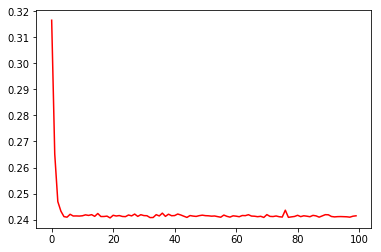

In [14]:
# train the parameters
history = model.fit ( train_X, train_y, epochs = 100, batch_size = batch_size, class_weight = class_weight )

# evaluate accuracy
train_acc = model.evaluate ( train_X, train_y, batch_size = 32 )[1]
test_acc = model.evaluate ( test_X, test_y, batch_size = 32 )[1]
print ( 'Training accuracy: %s' % train_acc )
print ( 'Testing accuracy: %s' % test_acc )

losses = history.history['loss']
plt.plot ( range ( len ( losses ) ), losses, 'r' )
plt.show()

In [15]:
def train_and_evaluate ( model, x_train, y_train, x_test, y_test, n = 20 ):
    train_accs = []
    test_accs = []
    with tqdm ( total = n ) as progress_bar:
        for _ in range(n):
            model.fit (
                x_train, 
                y_train, 
                epochs = epochs, 
                batch_size = batch_size, 
                class_weight = class_weight, 
                verbose = False )
            train_accs.append ( model.evaluate ( x_train, y_train, batch_size = 32, verbose = False )[1] )
            test_accs.append ( model.evaluate ( x_test, y_test, batch_size = 32, verbose = False )[1] )
            progress_bar.update()
    print ( 'Avgerage Training Accuracy: %s' % np.average ( train_accs ))
    print ( 'Avgerage Testing Accuracy: %s' % np.average ( test_accs ))
    return train_accs, test_accs

In [16]:
_, test_accs = train_and_evaluate ( model, train_X, train_y, test_X, test_y )

100%|██████████████████████████████████████████| 20/20 [01:24<00:00,  3.97s/it]


Avgerage Training Accuracy: 0.7949624389502203
Avgerage Testing Accuracy: 0.8174603193525284


### Discussion

#### How did you preprocess this dataset ?
    1. 將 Close Price （與前一天比較的）漲跌，存成新的 Column
    2. 切割資料：將 02-Jan-2009 ~ 29-Dec-2017 的資料設定為 Training_Data，將 02-Jan-2018 ~ 31-Dec-2018 的資料設定為 Testing_Data
    3. 資料視覺化：繪製散布圖與熱圖，做為選擇變數的依據
    4. 新增潛在變數：將 Open Price、High Price、Low Price （與前一天比較的）漲跌，存成新的 Column
    5. 重新繪製熱圖：做為選擇變數的依據
    6. 變數選取：選取相關係數 > 0.05 的變數為預測變數，最終以 Open Price、High Price、Low Price 的漲跌做為預測依據
    7. 切割資料：將資料分割成 train_X, train_y, test_X, test_y

#### Which classifier reaches the highest classification accuracy in this dataset ? Why ?
    SVC classifier reaches the highest classification accuracy, 82.14 %, in this dataset.
    The reason why SVC fits so well might because of the properties of this dataset.
    According to the "Scikit Learn Algorithm Cheat Sheet" , we can follow the steps from :
        1. > 50 samples : Yes
        2. Predicting a category : Yes
        3. Do you have labeled data : Yes
        4. < 100 K samples : Yes
        5. The proper methods might be Linear SVC, K Neighbors, SVC, Ensemble Classifiers

<img src="https://scikit-learn.org/stable/_static/ml_map.png" width="800px">



#### Can this result remain if the dataset is different ?
    It depends. If the different dataset have the mentioned properties, this classifier might be suitable. 
    Else, the "Scikit Learn Algorithm Cheat Sheet" might be a reference for people to see which classifier might be suitable.
    
#### How did you improve your classifiers ?
    I can improve my classifiers by :
    1. Adjusting parameters (maybe by cross-validation) 
    2. Using more information about time (because this is actually time series data)
